# Tumor Classification with FHE XGBoost

We will use the FHE XGBoost classifier to train a model on encrypted data and make predictions on encrypted data using this [dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset) for classification of tumors. The dataset contains features of a tumor, along with the label as benign or malignant. We will also train a sklearn XGBoost model side by side for comparison. 

(Based on Zama's tutorial on XGBoost, from [here](https://docs.zama.ai/concrete-ml/built-in-models/ml_examples).)

In [1]:
import warnings
import time
import matplotlib.pyplot as plt
import numpy
import pandas as pd
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    make_scorer,
    matthews_corrcoef,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost.sklearn import XGBClassifier as SklearnXGBClassifier

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Load the data-set
df = pd.read_csv("data/breast-cancer.csv")
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

# Split the data-set into predictors and target (X and y)
y = df["diagnosis"]
X = df.drop(["diagnosis"], axis=1)

In [3]:
# Create scorer with the MCC metric
grid_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)

# Define the number of estimators to consider for the following gridsearch
n_estimators = (
    [1, 5, 10, 20] + [20 * i for i in range(2, 11)] + [50 * i for i in range(5, 11)]
)

### Apply Grid-Search

In [4]:
fit_extra_param = {"eval_metric": "logloss"}

param_grid = {
    "max_depth": [2],
    "n_estimators": n_estimators,
}

sklearn_grid_search = GridSearchCV(
    SklearnXGBClassifier(),
    param_grid,
    cv=5,
    scoring=grid_scorer,
    error_score="raise",
    verbose=1,
)

sklearn_grid_search.fit(X, y, **fit_extra_param);

Fitting 5 folds for each of 19 candidates, totalling 95 fits


In [5]:
param_grid = {
    "n_bits": [6],
    "max_depth": [2],
    "n_estimators": n_estimators,
}

concrete_grid_search = GridSearchCV(
    ConcreteXGBClassifier(),
    param_grid,
    cv=5,
    scoring=grid_scorer,
    error_score="raise",
    verbose=1,
)

concrete_grid_search.fit(X, y);

Fitting 5 folds for each of 19 candidates, totalling 95 fits


In [6]:
# Print the best MCC score for both models
print(f"Best MCC score for Scikit-Learn: {sklearn_grid_search.best_score_:.2f}")
print(f"Best MCC score Concrete ML: {concrete_grid_search.best_score_:.2f}")

Best MCC score for Scikit-Learn: 0.94
Best MCC score Concrete ML: 0.95


### Plot the MCC score by number of estimators

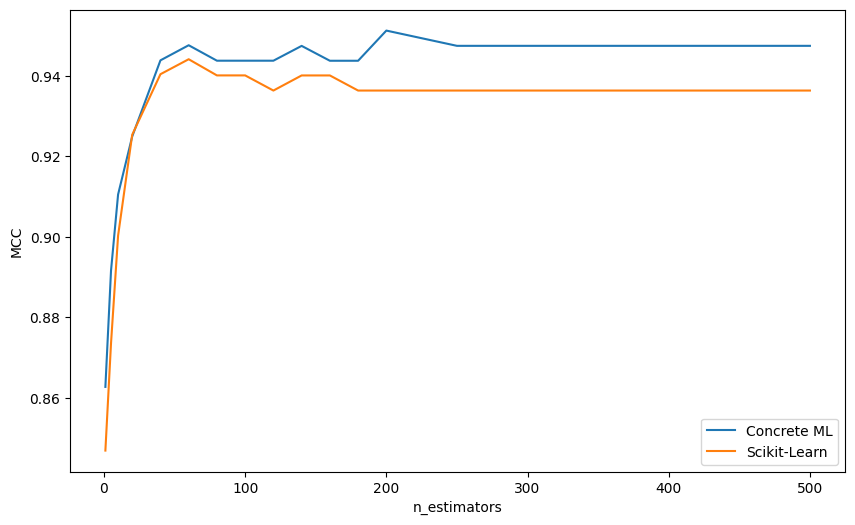

In [7]:
# Define the figure size
plt.figure(figsize=(10, 6))

# Plot the mean_test_score of both model along the n_estimators hyper parameter
plt.plot(
    concrete_grid_search.cv_results_["param_n_estimators"],
    concrete_grid_search.cv_results_["mean_test_score"],
    label="Concrete ML",
)
plt.plot(
    sklearn_grid_search.cv_results_["param_n_estimators"],
    sklearn_grid_search.cv_results_["mean_test_score"],
    label="Scikit-Learn",
)
plt.xlabel("n_estimators")
plt.ylabel("MCC")
plt.legend()
plt.show()

### 3) Execute the Inference in FHE with the best parameters


In [8]:
best_params_sklearn = sklearn_grid_search.best_params_
print(f"Best parameters found for the Scikit-Learn model: {best_params_sklearn}")

best_params_concrete = concrete_grid_search.best_params_
print(f"Best parameters found for the Concrete ML model: {best_params_concrete}")

Best parameters found for the Scikit-Learn model: {'max_depth': 2, 'n_estimators': 60}
Best parameters found for the Concrete ML model: {'max_depth': 2, 'n_bits': 6, 'n_estimators': 200}


In [9]:
# Define the Concrete ML and Scikit-Learn models
concrete_model = ConcreteXGBClassifier(**best_params_concrete)
sklearn_model = SklearnXGBClassifier(**best_params_sklearn)

# Split the data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Fit both models
concrete_model.fit(X_train, y_train, **fit_extra_param)
sklearn_model.fit(X_train, y_train, **fit_extra_param);

### Compile and Generate the Keys

Compiling the Concrete ML model builds the underlying FHE circuit needed for running the inference
in FHE. Once this is done, the FHE keys can be generated.

In [10]:
# Compile the Concrete ML model using the training data
circuit = concrete_model.compile(X_train)

In [11]:
print(
    f"Generating a key for an {circuit.graph.maximum_integer_bit_width()}-bits circuit"
)

# Generate the key
time_begin = time.time()
circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Generating a key for an 8-bits circuit
Key generation time: 1.91 seconds


### Evaluate the Models

In [12]:
# Compute the predictions using the Scikit-Learn model
y_pred_sklearn = sklearn_model.predict(X_test)

# Compute the predictions using the Concrete ML model with FHE simulation
y_pred_simulated = concrete_model.predict(X_test, fhe="simulate")

In [13]:
print("Accuracy scores:")
print(
    f"- Scikit-Learn (clear floating points): {accuracy_score(y_test, y_pred_sklearn)*100:.2f}%\n"
    f"- Concrete ML (clear quantized): {accuracy_score(y_test, y_pred_simulated)*100:.2f}%\n"
)

Accuracy scores:
- Scikit-Learn (clear floating points): 96.49%
- Concrete ML (clear quantized): 96.49%



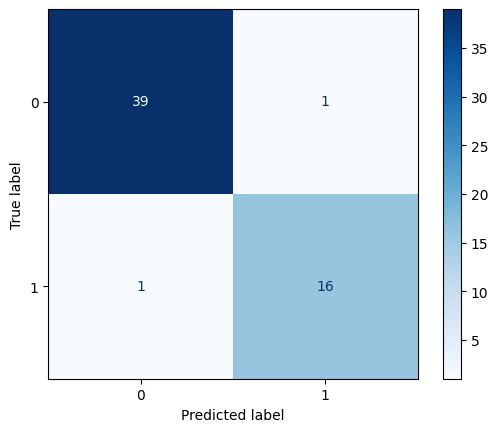

In [14]:
# Compute the confusion matrix for Concrete ML
cm = confusion_matrix(y_test, y_pred_simulated)

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.show()

### FHE Execution

Execute inference and verify the results are the same as the clear result

In [15]:
N_SAMPLE_FHE = 10

# Pick N_SAMPLE_FHE random samples from the test set
idx_test = numpy.random.choice(X_test.shape[0], N_SAMPLE_FHE, replace=False)
X_test_fhe = X_test.iloc[idx_test]
y_test_fhe = y_test.iloc[idx_test]

# Compute the predictions using the Concrete ML (quantized) model in the clear
y_preds_clear = concrete_model.predict(X_test_fhe)

# Compute the predictions using the Concrete ML model in FHE
time_begin = time.time()
y_preds_fhe = concrete_model.predict(X_test_fhe, fhe="execute")
print(
    f"FHE execution time: {(time.time() - time_begin) / len(X_test_fhe):.2f} seconds per sample"
)

FHE execution time: 34.91 seconds per sample


In [16]:
# Compare the clear quantized inference vs FHE inference
print(
    f"{(y_preds_fhe == y_preds_clear).sum()}/{N_SAMPLE_FHE} "
    "FHE predictions match the clear quantized predictions"
)

10/10 FHE predictions match the clear quantized predictions


In [17]:
# See prediction vs ground truth
print("Prediction vs ground truth:")
print(f"Ground truth: {y_test_fhe.values}")
print(f"Prediction:   {y_preds_fhe}")

Prediction vs ground truth:
Ground truth: [0 1 1 1 0 0 0 0 0 0]
Prediction:   [0 1 1 1 0 0 0 0 0 0]
